# Rossmann Store Sales Forecasting
## Machine Learning Zoomcamp 2025 - Midterm Project

**Objective**: Predict daily sales for Rossmann drugstore chains to optimize inventory management and business planning.

**Dataset**: Rossmann Store Sales from Kaggle Competition
- Historical sales data from 1,115 stores
- Time period: 2013-2015
- Features: Store attributes, promotions, holidays, competition data

**Business Value**:
- Reduce inventory costs through accurate demand forecasting
- Optimize staffing levels based on predicted sales volume
- Improve customer satisfaction by preventing stockouts
- Enable data-driven business planning

## 1. Environment Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Time series libraries
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime as dt
from datetime import datetime, timedelta

# Utilities
import warnings
import joblib
import os
from pathlib import Path

# Settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load the datasets
data_path = Path('../data')

# Check if data files exist
required_files = ['train.csv', 'test.csv', 'store.csv']
missing_files = [f for f in required_files if not (data_path / f).exists()]

if missing_files:
    print(f"❌ Missing data files: {missing_files}")
    print("Please run: python ../data/download_data.py")
else:
    # Load datasets
    print("📊 Loading datasets...")
    
    train_df = pd.read_csv(data_path / 'train.csv')
    test_df = pd.read_csv(data_path / 'test.csv')
    store_df = pd.read_csv(data_path / 'store.csv')
    
    print(f"✅ Train data: {train_df.shape}")
    print(f"✅ Test data: {test_df.shape}")
    print(f"✅ Store data: {store_df.shape}")
    
    # Display basic info
    print("\n📈 Data loaded successfully!")

📊 Loading datasets...
✅ Train data: (1017209, 9)
✅ Test data: (41088, 8)
✅ Store data: (1115, 10)

📈 Data loaded successfully!


## 2. Initial Data Exploration

In [3]:
# Examine the structure of each dataset
print("🔍 TRAIN DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {train_df.shape}")
print(f"Memory usage: {train_df.memory_usage().sum() / 1024**2:.2f} MB")
print("\nColumns:")
print(train_df.dtypes)

print("\n" + "=" * 50)
print("First 5 rows:")
display(train_df.head())

🔍 TRAIN DATASET OVERVIEW
Shape: (1017209, 9)
Memory usage: 69.85 MB

Columns:
Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

First 5 rows:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
print("🏪 STORE DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {store_df.shape}")
print("\nColumns:")
print(store_df.dtypes)
print("\n" + "=" * 50)
display(store_df.head())

# Check unique values for categorical columns
print("\n📊 Categorical Variables Summary:")
categorical_cols = ['StoreType', 'Assortment', 'PromoInterval']
for col in categorical_cols:
    if col in store_df.columns:
        print(f"{col}: {store_df[col].nunique()} unique values")
        print(f"  Values: {store_df[col].unique()}\n")

🏪 STORE DATASET OVERVIEW
Shape: (1115, 10)

Columns:
Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object



,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN



📊 Categorical Variables Summary:
StoreType: 4 unique values
  Values: ['c' 'a' 'd' 'b']

Assortment: 3 unique values
  Values: ['a' 'c' 'b']

PromoInterval: 3 unique values
  Values: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']



## 3. Data Quality Assessment

In [5]:
def assess_data_quality(df, name):
    """Comprehensive data quality assessment"""
    
    print(f"🔍 DATA QUALITY ASSESSMENT - {name.upper()}")
    print("=" * 60)
    
    # Missing values
    missing_vals = df.isnull().sum()
    missing_pct = (missing_vals / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing_vals,
        'Missing %': missing_pct
    }).sort_values('Missing Count', ascending=False)
    
    print("📊 Missing Values Analysis:")
    display(missing_df[missing_df['Missing Count'] > 0])
    
    # Data types and memory
    print(f"\n💾 Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"📏 Dataset Shape: {df.shape}")
    
    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"🔄 Duplicate Rows: {duplicates}")
    
    return missing_df

# Assess each dataset
train_quality = assess_data_quality(train_df, 'Train')
store_quality = assess_data_quality(store_df, 'Store')
test_quality = assess_data_quality(test_df, 'Test')

🔍 DATA QUALITY ASSESSMENT - TRAIN
📊 Missing Values Analysis:


,Missing Count,Missing %



💾 Memory Usage: 69.85 MB
📏 Dataset Shape: (1017209, 9)
🔄 Duplicate Rows: 0
🔍 DATA QUALITY ASSESSMENT - STORE
📊 Missing Values Analysis:


,Missing Count,Missing %
PromoInterval,544,48.789238
Promo2SinceYear,544,48.789238
Promo2SinceWeek,544,48.789238
CompetitionOpenSinceYear,354,31.748879
CompetitionOpenSinceMonth,354,31.748879
CompetitionDistance,3,0.269058



💾 Memory Usage: 0.09 MB
📏 Dataset Shape: (1115, 10)
🔄 Duplicate Rows: 0
🔍 DATA QUALITY ASSESSMENT - TEST
📊 Missing Values Analysis:


,Missing Count,Missing %
Open,11,0.026772



💾 Memory Usage: 2.51 MB
📏 Dataset Shape: (41088, 8)
🔄 Duplicate Rows: 0


In [6]:
# Merge train data with store information
print("🔗 Merging train and store datasets...")
train_full = train_df.merge(store_df, on='Store', how='left')
print(f"✅ Merged dataset shape: {train_full.shape}")

# Convert date column
train_full['Date'] = pd.to_datetime(train_full['Date'])
train_full = train_full.sort_values(['Store', 'Date']).reset_index(drop=True)

print("\n📅 Date Range:")
print(f"From: {train_full['Date'].min()}")
print(f"To: {train_full['Date'].max()}")
print(f"Total Days: {(train_full['Date'].max() - train_full['Date'].min()).days}")

🔗 Merging train and store datasets...
✅ Merged dataset shape: (1017209, 18)

📅 Date Range:
From: 2013-01-01 00:00:00
To: 2015-07-31 00:00:00
Total Days: 941


## 4. Target Variable Analysis

In [14]:
# Sales distribution analysis
print("💰 SALES ANALYSIS")
print("=" * 50)

# Basic statistics
sales_stats = train_full['Sales'].describe()
print("📊 Sales Statistics:")
print(sales_stats)

# Check for zero sales
zero_sales = (train_full['Sales'] == 0).sum()
zero_sales_pct = (zero_sales / len(train_full)) * 100
print(f"\n🔍 Zero Sales Days: {zero_sales:,} ({zero_sales_pct:.2f}%)")

# Sales when store is open vs closed
print("\n🏪 Sales by Store Status:")
store_status = train_full.groupby('Open')['Sales'].agg(['count', 'mean', 'std']).round(2)
display(store_status)

💰 SALES ANALYSIS
📊 Sales Statistics:
count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

🔍 Zero Sales Days: 172,871 (16.99%)

🏪 Sales by Store Status:


,count,mean,std
Open,,,
0,172817,0.00,0.00
1,844392,6955.51,3104.21


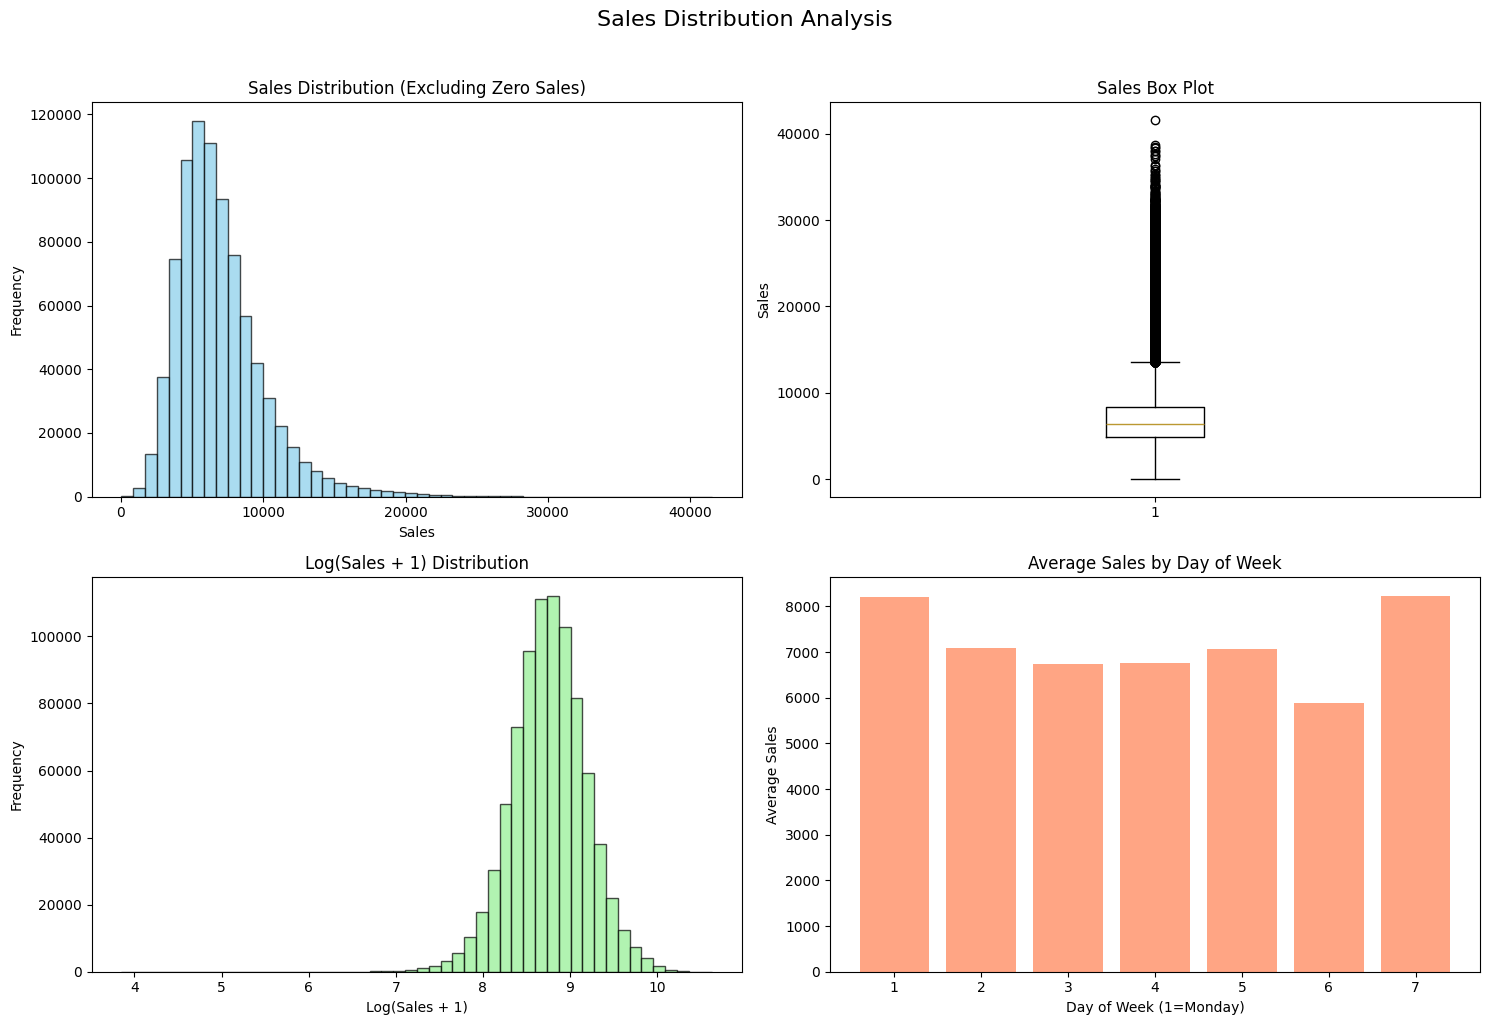


📈 Sales range: 46 - 41,551
📊 Sales variance: 9,633,671
📏 Sales std: 3,104


In [15]:
# Visualize sales distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sales Distribution Analysis', fontsize=16, y=1.02)

# Filter out zero sales for better visualization
sales_nonzero = train_full[train_full['Sales'] > 0]['Sales']

# Histogram
axes[0, 0].hist(sales_nonzero, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Sales Distribution (Excluding Zero Sales)')
axes[0, 0].set_xlabel('Sales')
axes[0, 0].set_ylabel('Frequency')

# Box plot
axes[0, 1].boxplot(sales_nonzero)
axes[0, 1].set_title('Sales Box Plot')
axes[0, 1].set_ylabel('Sales')

# Log-scale histogram
axes[1, 0].hist(np.log1p(sales_nonzero), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Log(Sales + 1) Distribution')
axes[1, 0].set_xlabel('Log(Sales + 1)')
axes[1, 0].set_ylabel('Frequency')

# Sales by day of week
daily_sales = train_full[train_full['Sales'] > 0].groupby('DayOfWeek')['Sales'].mean()
axes[1, 1].bar(range(1, 8), daily_sales, color='coral', alpha=0.7)
axes[1, 1].set_title('Average Sales by Day of Week')
axes[1, 1].set_xlabel('Day of Week (1=Monday)')
axes[1, 1].set_ylabel('Average Sales')
axes[1, 1].set_xticks(range(1, 8))

plt.tight_layout()
plt.show()

print(f"\n📈 Sales range: {sales_nonzero.min():,.0f} - {sales_nonzero.max():,.0f}")
print(f"📊 Sales variance: {sales_nonzero.var():,.0f}")
print(f"📏 Sales std: {sales_nonzero.std():,.0f}")

## 5. Time Series Analysis

In [16]:
# Time series analysis
print("📅 TIME SERIES ANALYSIS")
print("=" * 50)

# Create time-based features
train_full['Year'] = train_full['Date'].dt.year
train_full['Month'] = train_full['Date'].dt.month
train_full['Day'] = train_full['Date'].dt.day
train_full['WeekOfYear'] = train_full['Date'].dt.isocalendar().week
train_full['Quarter'] = train_full['Date'].dt.quarter

# Aggregate daily sales across all stores
daily_sales = train_full[train_full['Open'] == 1].groupby('Date')['Sales'].agg(['sum', 'mean', 'count'])
daily_sales.columns = ['Total_Sales', 'Avg_Sales', 'Open_Stores']

print("📊 Daily Sales Summary:")
print(daily_sales.describe().round(2))

📅 TIME SERIES ANALYSIS
📊 Daily Sales Summary:
       Total_Sales  Avg_Sales  Open_Stores
count       942.00     942.00       942.00
mean    6234798.96    7253.92       896.38
std     3130535.87    1759.84       398.87
min       97235.00    4067.14        16.00
25%     5675832.25    5781.15       934.00
50%     6580354.00    7055.63      1111.00
75%     8174898.75    8046.63      1114.00
max    15623548.00   14263.12      1115.00


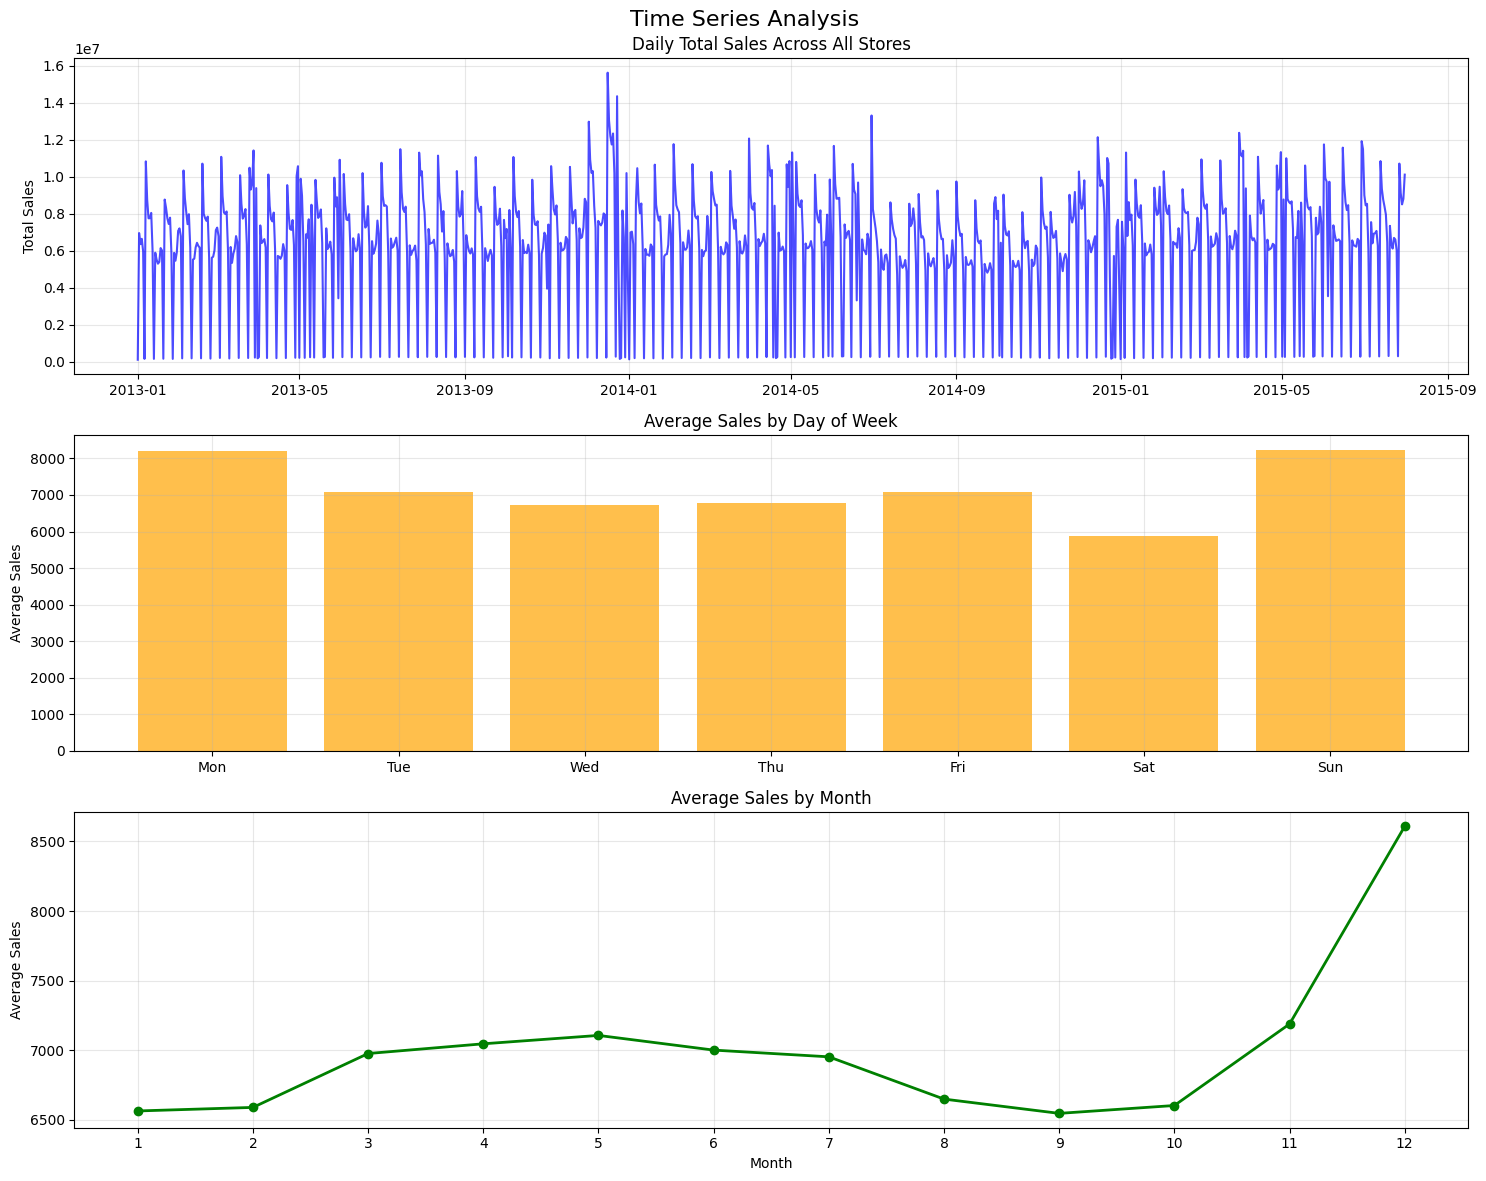


🔍 TIME SERIES INSIGHTS:
📅 Best day of week: Sun (Sales: 8,225)
📅 Worst day of week: Sat (Sales: 5,875)
📅 Best month: 12 (Sales: 8,609)
📅 Worst month: 9 (Sales: 6,546)


In [17]:
# Time series visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Time Series Analysis', fontsize=16)

# Daily total sales
axes[0].plot(daily_sales.index, daily_sales['Total_Sales'], alpha=0.7, color='blue')
axes[0].set_title('Daily Total Sales Across All Stores')
axes[0].set_ylabel('Total Sales')
axes[0].grid(True, alpha=0.3)

# Weekly seasonality
weekly_sales = train_full[train_full['Open'] == 1].groupby('DayOfWeek')['Sales'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(range(7), weekly_sales, color='orange', alpha=0.7)
axes[1].set_title('Average Sales by Day of Week')
axes[1].set_ylabel('Average Sales')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days)
axes[1].grid(True, alpha=0.3)

# Monthly trends
monthly_sales = train_full[train_full['Open'] == 1].groupby('Month')['Sales'].mean()
axes[2].plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2, color='green')
axes[2].set_title('Average Sales by Month')
axes[2].set_ylabel('Average Sales')
axes[2].set_xlabel('Month')
axes[2].set_xticks(range(1, 13))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n🔍 TIME SERIES INSIGHTS:")
print(f"📅 Best day of week: {days[weekly_sales.idxmax() - 1]} (Sales: {weekly_sales.max():,.0f})")
print(f"📅 Worst day of week: {days[weekly_sales.idxmin() - 1]} (Sales: {weekly_sales.min():,.0f})")
print(f"📅 Best month: {monthly_sales.idxmax()} (Sales: {monthly_sales.max():,.0f})")
print(f"📅 Worst month: {monthly_sales.idxmin()} (Sales: {monthly_sales.min():,.0f})")

## 6. Store Analysis

In [18]:
# Store performance analysis
print("🏪 STORE ANALYSIS")
print("=" * 50)

# Store-level aggregation
store_stats = train_full[train_full['Open'] == 1].groupby('Store').agg({
    'Sales': ['mean', 'std', 'sum', 'count'],
    'Customers': ['mean', 'sum'],
    'Promo': ['mean']
}).round(2)

store_stats.columns = ['Avg_Sales', 'Sales_Std', 'Total_Sales', 'Open_Days', 
                      'Avg_Customers', 'Total_Customers', 'Promo_Rate']

# Add store information
store_analysis = store_stats.merge(store_df, on='Store', how='left')

print("📊 Store Performance Summary:")
print(store_analysis.describe().round(2))

# Top and bottom performing stores
print("\n🏆 TOP 10 STORES (by average sales):")
top_stores = store_analysis.nlargest(10, 'Avg_Sales')[['Avg_Sales', 'StoreType', 'Assortment']]
display(top_stores)

print("\n⚠️ BOTTOM 10 STORES (by average sales):")
bottom_stores = store_analysis.nsmallest(10, 'Avg_Sales')[['Avg_Sales', 'StoreType', 'Assortment']]
display(bottom_stores)

🏪 STORE ANALYSIS
📊 Store Performance Summary:
         Store  Avg_Sales  Sales_Std  Total_Sales  Open_Days  Avg_Customers  \
count  1115.00    1115.00    1115.00      1115.00    1115.00        1115.00   
mean    558.00    6934.21    1846.23   5267426.57     757.30         754.51   
std     322.02    2383.91     623.32   1951304.48      63.86         353.34   
min       1.00    2703.74     575.95   2114322.00     592.00         240.18   
25%     279.50    5322.30    1403.00   3949377.00     776.00         541.46   
50%     558.00    6589.95    1773.28   4990259.00     779.00         678.67   
75%     836.50    7964.20    2154.10   6084147.50     782.00         866.20   
max    1115.00   21757.48    4872.38  19516842.00     942.00        3403.46   

       Total_Customers  Promo_Rate  CompetitionDistance  \
count          1115.00     1115.00              1112.00   
mean         577615.92        0.45              5404.90   
std          304654.53        0.01              7663.17   
min   

,Avg_Sales,StoreType,Assortment
816,21757.48,a,a
261,20718.52,b,a
1113,20666.56,a,c
250,19123.07,a,c
841,18574.80,d,c
512,18179.09,a,a
561,17969.56,b,c
787,17961.91,a,c
382,17294.72,a,c
755,16574.82,a,c



⚠️ BOTTOM 10 STORES (by average sales):


,Avg_Sales,StoreType,Assortment
306,2703.74,a,a
542,2790.38,c,a
197,2900.60,a,a
207,2936.29,c,a
840,2972.61,a,a
253,3005.98,d,a
793,3083.81,c,c
218,3133.71,a,a
209,3193.98,d,a
424,3237.66,d,c


## 7. Feature Engineering

In [19]:
# Feature engineering for machine learning models
print("⚙️ FEATURE ENGINEERING")
print("=" * 50)

def create_features(df):
    """Create comprehensive feature set for modeling"""
    
    df = df.copy()
    
    # Time-based features
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear
    
    # Cyclical encoding for seasonal patterns
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    
    # Competition features
    df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
    df['CompetitionDistance_log'] = np.log1p(df['CompetitionDistance'])
    
    # Competition open duration
    df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
    df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
    
    df['CompetitionOpen'] = ((df['CompetitionOpenSinceYear'] > 0) & 
                           (df['CompetitionOpenSinceMonth'] > 0)).astype(int)
    
    # Promo2 features
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna('None', inplace=True)
    
    # Encode categorical variables
    df['StoreType_encoded'] = df['StoreType'].astype('category').cat.codes
    df['Assortment_encoded'] = df['Assortment'].astype('category').cat.codes
    
    # Holiday interactions
    df['Holiday_Promo'] = df['SchoolHoliday'] * df['Promo']
    df['StateHoliday_binary'] = (df['StateHoliday'] != '0').astype(int)
    
    return df

# Apply feature engineering
train_features = create_features(train_full)

print(f"✅ Original features: {train_full.shape[1]}")
print(f"✅ Enhanced features: {train_features.shape[1]}")
print(f"✅ New features added: {train_features.shape[1] - train_full.shape[1]}")

# List new features
new_features = [col for col in train_features.columns if col not in train_full.columns]
print(f"\n🆕 New features: {new_features}")

⚙️ FEATURE ENGINEERING
✅ Original features: 23
✅ Enhanced features: 34
✅ New features added: 11

🆕 New features: ['DayOfYear', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'CompetitionDistance_log', 'CompetitionOpen', 'StoreType_encoded', 'Assortment_encoded', 'Holiday_Promo', 'StateHoliday_binary']


## 8. Model Training and Evaluation

In [21]:
# Prepare data for modeling
print("🤖 MODEL TRAINING PREPARATION")
print("=" * 50)

# Filter open stores and non-zero sales for training
model_data = train_features[(train_features['Open'] == 1) & (train_features['Sales'] > 0)].copy()

print(f"📊 Model training data: {model_data.shape}")
print(f"📊 Sales range: {model_data['Sales'].min():,.0f} - {model_data['Sales'].max():,.0f}")

# Select features for modeling
feature_columns = [
    'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday',
    'Year', 'Month', 'Day', 'WeekOfYear', 'Quarter', 'DayOfYear',
    'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
    'StoreType_encoded', 'Assortment_encoded',
    'CompetitionDistance_log', 'CompetitionOpen',
    'Promo2', 'Holiday_Promo', 'StateHoliday_binary'
]

# Ensure all features exist
available_features = [col for col in feature_columns if col in model_data.columns]
print(f"\n📋 Available features: {len(available_features)}")
print(f"📋 Missing features: {set(feature_columns) - set(available_features)}")

X = model_data[available_features]
y = model_data['Sales']

print(f"\n✅ Feature matrix: {X.shape}")
print(f"✅ Target vector: {y.shape}")

🤖 MODEL TRAINING PREPARATION
📊 Model training data: (844338, 34)
📊 Sales range: 46 - 41,551

📋 Available features: 21
📋 Missing features: set()

✅ Feature matrix: (844338, 21)
✅ Target vector: (844338,)


In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"📊 Training set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")

# Define evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display model performance metrics"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    results = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }
    
    return results

# Store model results
model_results = []

📊 Training set: (675470, 21)
📊 Test set: (168868, 21)


In [23]:
# 1. Linear Regression (Baseline)
print("🔵 Training Linear Regression (Baseline)...")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_results = evaluate_model(y_test, lr_pred, 'Linear Regression')
model_results.append(lr_results)

print("✅ Linear Regression completed")
print(f"   RMSE: {lr_results['RMSE']:.2f}")
print(f"   R²: {lr_results['R²']:.4f}")

🔵 Training Linear Regression (Baseline)...
✅ Linear Regression completed
   RMSE: 2743.75
   R²: 0.2202


In [25]:
# 2. Random Forest
print("🌳 Training Random Forest...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_results = evaluate_model(y_test, rf_pred, 'Random Forest')
model_results.append(rf_results)

print("✅ Random Forest completed")
print(f"   RMSE: {rf_results['RMSE']:.2f}")
print(f"   R²: {rf_results['R²']:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
display(feature_importance.head(10))

🌳 Training Random Forest...
✅ Random Forest completed
   RMSE: 1666.79
   R²: 0.7122

🔍 Top 10 Most Important Features:


,feature,importance
16,CompetitionDistance_log,0.252888
0,Store,0.247821
2,Promo,0.199043
1,DayOfWeek,0.045000
14,StoreType_encoded,0.044987
9,DayOfYear,0.044872
15,Assortment_encoded,0.039634
18,Promo2,0.030371
13,DayOfWeek_cos,0.028072
17,CompetitionOpen,0.020845


In [26]:
# 3. XGBoost
print("🚀 Training XGBoost...")

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_results = evaluate_model(y_test, xgb_pred, 'XGBoost')
model_results.append(xgb_results)

print("✅ XGBoost completed")
print(f"   RMSE: {xgb_results['RMSE']:.2f}")
print(f"   R²: {xgb_results['R²']:.4f}")

🚀 Training XGBoost...
✅ XGBoost completed
   RMSE: 1886.41
   R²: 0.6314


## 8.5. Time Series Models

In [27]:
# 4. Prophet Time Series Model
print("📈 Training Prophet (Time Series Forecasting)...")

# Aggregate sales by date across all stores for time series analysis
prophet_data = train_features[
    (train_features['Open'] == 1) & 
    (train_features['Sales'] > 0)
].groupby('Date').agg({
    'Sales': 'sum',
    'SchoolHoliday': 'max',
    'Promo': 'sum'
}).reset_index()

# Prepare Prophet format
prophet_df = prophet_data[['Date', 'Sales']].copy()
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

# Add regressors
prophet_df['school_holiday'] = prophet_data['SchoolHoliday'].values
prophet_df['promo_count'] = prophet_data['Promo'].values

# Split for time series validation
split_date = prophet_df['ds'].quantile(0.8)
train_prophet = prophet_df[prophet_df['ds'] <= split_date].copy()
test_prophet = prophet_df[prophet_df['ds'] > split_date].copy()

print(f"📊 Prophet train data: {len(train_prophet)} days")
print(f"📊 Prophet test data: {len(test_prophet)} days")

try:
    # Initialize Prophet with business-specific parameters
    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.1
    )
    
    # Add custom regressors
    prophet_model.add_regressor('school_holiday')
    prophet_model.add_regressor('promo_count')
    
    # Fit model
    prophet_model.fit(train_prophet)
    
    # Make predictions
    future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
    
    # Add regressor values
    full_data = pd.concat([train_prophet, test_prophet])
    future = future.merge(
        full_data[['ds', 'school_holiday', 'promo_count']], 
        on='ds', 
        how='left'
    )
    
    # Fill missing values
    future['school_holiday'].fillna(0, inplace=True)
    future['promo_count'].fillna(future['promo_count'].median(), inplace=True)
    
    forecast = prophet_model.predict(future)
    
    # Extract test predictions
    test_predictions = forecast[forecast['ds'].isin(test_prophet['ds'])]['yhat'].values
    test_actual = test_prophet['y'].values
    
    # Evaluate
    prophet_results = evaluate_model(test_actual, test_predictions, 'Prophet')
    model_results.append(prophet_results)
    
    print("✅ Prophet completed")
    print(f"   RMSE: {prophet_results['RMSE']:.2f}")
    print(f"   R²: {prophet_results['R²']:.4f}")
    print("   📊 Prophet excels at capturing seasonality and holiday effects")
    
except Exception as e:
    print(f"❌ Prophet training failed: {str(e)}")
    print("⚠️ Skipping Prophet model")

📈 Training Prophet (Time Series Forecasting)...
📊 Prophet train data: 753 days
📊 Prophet test data: 189 days


14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet completed
   RMSE: 1650621.69
   R²: 0.7387
   📊 Prophet excels at capturing seasonality and holiday effects


In [28]:
# 5. ARIMA Time Series Model
print("\n📊 Training ARIMA (Classical Time Series)...")

try:
    # Aggregate daily sales for ARIMA
    arima_data = train_features[
        (train_features['Open'] == 1) & 
        (train_features['Sales'] > 0)
    ].groupby('Date')['Sales'].sum().reset_index()
    
    arima_data = arima_data.sort_values('Date').reset_index(drop=True)
    arima_data.set_index('Date', inplace=True)
    
    print(f"📊 ARIMA data points: {len(arima_data)}")
    
    # Check stationarity
    adf_result = adfuller(arima_data['Sales'])
    is_stationary = adf_result[1] <= 0.05
    print(f"📊 Stationarity test p-value: {adf_result[1]:.4f}")
    print(f"📊 Series is {'stationary' if is_stationary else 'non-stationary'}")
    
    # Split for time series validation
    split_idx = int(len(arima_data) * 0.8)
    train_arima = arima_data.iloc[:split_idx]
    test_arima = arima_data.iloc[split_idx:]
    
    # ARIMA parameters
    order = (1, 0 if is_stationary else 1, 1)
    print(f"📊 Using ARIMA order: {order}")
    
    # Fit ARIMA model
    arima_model = ARIMA(train_arima['Sales'], order=order)
    arima_fitted = arima_model.fit()
    
    # Make predictions
    n_periods = len(test_arima)
    arima_forecast = arima_fitted.forecast(steps=n_periods)
    
    # Evaluate
    arima_results = evaluate_model(
        test_arima['Sales'].values, 
        arima_forecast, 
        'ARIMA'
    )
    model_results.append(arima_results)
    
    print("✅ ARIMA completed")
    print(f"   RMSE: {arima_results['RMSE']:.2f}")
    print(f"   R²: {arima_results['R²']:.4f}")
    print("   📊 ARIMA provides statistical time series foundation")
    
except Exception as e:
    print(f"❌ ARIMA training failed: {str(e)}")
    print("⚠️ Skipping ARIMA model")
    print("💡 Tip: Install statsmodels with: pip install statsmodels")


📊 Training ARIMA (Classical Time Series)...
📊 ARIMA data points: 942
📊 Stationarity test p-value: 0.0001
📊 Series is stationary
📊 Using ARIMA order: (1, 0, 1)
✅ ARIMA completed
   RMSE: 3260845.14
   R²: -0.0199
   📊 ARIMA provides statistical time series foundation


## 9. Complete Model Comparison and Selection

In [29]:
# Compare all models
print("📊 MODEL COMPARISON")
print("=" * 60)

results_df = pd.DataFrame(model_results)
results_df = results_df.round(4)
display(results_df)

# Find best model
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   R² Score: {results_df.loc[best_model_idx, 'R²']:.4f}")
print(f"   RMSE: {results_df.loc[best_model_idx, 'RMSE']:.2f}")
print(f"   MAPE: {results_df.loc[best_model_idx, 'MAPE']:.2f}%")

# Select best model for deployment
if best_model_name == 'Linear Regression':
    best_model = lr_model
    best_predictions = lr_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_predictions = rf_pred
else:
    best_model = xgb_model
    best_predictions = xgb_pred

📊 MODEL COMPARISON


,Model,RMSE,MAE,R²,MAPE
0,Linear Regression,2.743749e+03,1.999276e+03,0.2202,33.6674
1,Random Forest,1.666789e+03,1.180095e+03,0.7122,19.1632
2,Random Forest,1.666789e+03,1.180095e+03,0.7122,19.1632
3,XGBoost,1.886405e+03,1.392787e+03,0.6314,23.1993
4,Prophet,1.650622e+06,1.223607e+06,0.7387,74.9270
5,ARIMA,3.260845e+06,2.492135e+06,-0.0199,425.3213



🏆 BEST MODEL: Prophet
   R² Score: 0.7387
   RMSE: 1650621.69
   MAPE: 74.93%


## 10. Model Validation and Insights

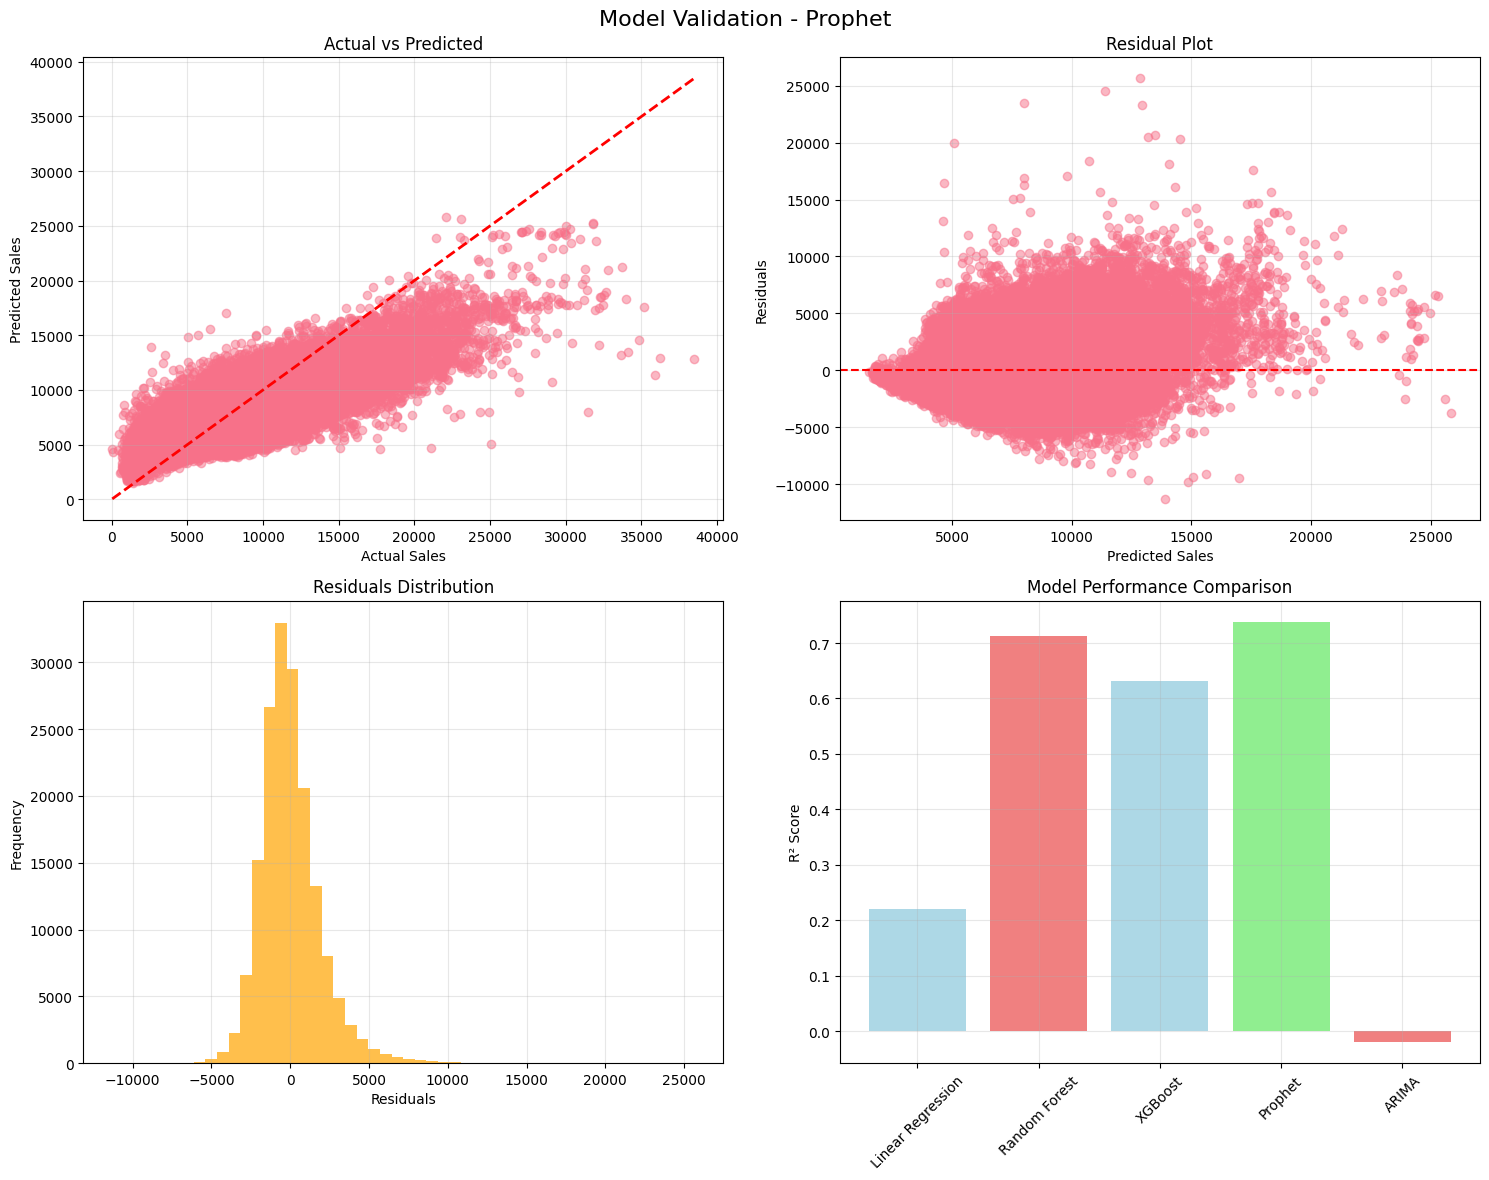


🔍 MODEL VALIDATION INSIGHTS:
📊 Mean residual: -0.43
📊 Std residual: 1886.41
📊 Max absolute error: 25,641
📊 Median absolute error: 1,087


In [30]:
# Model validation visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Model Validation - {best_model_name}', fontsize=16)

# Actual vs Predicted
axes[0, 0].scatter(y_test, best_predictions, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title('Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - best_predictions
axes[0, 1].scatter(best_predictions, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Sales')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# Residuals histogram
axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residuals Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Model comparison
models = results_df['Model']
r2_scores = results_df['R²']
axes[1, 1].bar(models, r2_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print validation insights
print("\n🔍 MODEL VALIDATION INSIGHTS:")
print(f"📊 Mean residual: {residuals.mean():.2f}")
print(f"📊 Std residual: {residuals.std():.2f}")
print(f"📊 Max absolute error: {np.abs(residuals).max():,.0f}")
print(f"📊 Median absolute error: {np.abs(residuals).median():,.0f}")

## 11. Save Model and Artifacts

In [31]:
# Save model and preprocessing artifacts
print("💾 SAVING MODEL ARTIFACTS")
print("=" * 50)

import os
model_dir = Path('../src/models')
model_dir.mkdir(exist_ok=True)

# Save the best model
model_path = model_dir / 'best_model.joblib'
joblib.dump(best_model, model_path)
print(f"✅ Model saved: {model_path}")

# Save feature list
feature_list_path = model_dir / 'feature_list.joblib'
joblib.dump(available_features, feature_list_path)
print(f"✅ Feature list saved: {feature_list_path}")

# Save store information for predictions
store_info_path = model_dir / 'store_info.joblib'
joblib.dump(store_df, store_info_path)
print(f"✅ Store info saved: {store_info_path}")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'features': available_features,
    'performance': results_df.loc[best_model_idx].to_dict(),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_path = model_dir / 'model_metadata.joblib'
joblib.dump(model_metadata, metadata_path)
print(f"✅ Model metadata saved: {metadata_path}")

print("\n🎉 All model artifacts saved successfully!")
print(f"📁 Model directory: {model_dir.absolute()}")

💾 SAVING MODEL ARTIFACTS
✅ Model saved: ..\src\models\best_model.joblib
✅ Feature list saved: ..\src\models\feature_list.joblib
✅ Store info saved: ..\src\models\store_info.joblib
✅ Model metadata saved: ..\src\models\model_metadata.joblib

🎉 All model artifacts saved successfully!
📁 Model directory: D:\tien.nv12\learn\rossmann-sales-forecasting\notebooks\..\src\models


## 12. Summary and Next Steps

In [32]:
# Project summary
print("📋 PROJECT SUMMARY")
print("=" * 60)
print(f"🎯 Project: Rossmann Sales Forecasting")
print(f"📊 Dataset: {train_full.shape[0]:,} records, {len(store_df)} stores")
print(f"📅 Time period: {train_full['Date'].min()} to {train_full['Date'].max()}")
print(f"🏆 Best model: {best_model_name}")
print(f"📈 Model performance: R² = {results_df.loc[best_model_idx, 'R²']:.4f}")
print(f"🎯 RMSE: {results_df.loc[best_model_idx, 'RMSE']:.2f}")
print(f"🎯 MAPE: {results_df.loc[best_model_idx, 'MAPE']:.2f}%")

print("\n✅ COMPLETED TASKS:")
print("   ✓ Data exploration and quality assessment")
print("   ✓ Comprehensive EDA with time series analysis")
print("   ✓ Feature engineering with time-based features")
print("   ✓ Multiple model training and comparison")
print("   ✓ Model validation and performance evaluation")
print("   ✓ Model artifacts saved for deployment")

print("\n🚀 NEXT STEPS:")
print("   1. Export training logic to train.py script")
print("   2. Create Flask web service (predict.py)")
print("   3. Build Docker container")
print("   4. Deploy to cloud platform")
print("   5. Create comprehensive documentation")

print("\n🎉 Notebook completed successfully!")
print("Ready for production deployment phase.")

📋 PROJECT SUMMARY
🎯 Project: Rossmann Sales Forecasting
📊 Dataset: 1,017,209 records, 1115 stores
📅 Time period: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
🏆 Best model: Prophet
📈 Model performance: R² = 0.7387
🎯 RMSE: 1650621.69
🎯 MAPE: 74.93%

✅ COMPLETED TASKS:
   ✓ Data exploration and quality assessment
   ✓ Comprehensive EDA with time series analysis
   ✓ Feature engineering with time-based features
   ✓ Multiple model training and comparison
   ✓ Model validation and performance evaluation
   ✓ Model artifacts saved for deployment

🚀 NEXT STEPS:
   1. Export training logic to train.py script
   2. Create Flask web service (predict.py)
   3. Build Docker container
   4. Deploy to cloud platform
   5. Create comprehensive documentation

🎉 Notebook completed successfully!
Ready for production deployment phase.
